In [2]:
## IMPORTS
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [4]:
## some random stuff
# Check if pytorch can access the GPU
print("Is GPU available:", torch.cuda.is_available())
print("Number of GPUS:", torch.cuda.device_count())

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
           'V', 'W', 'X', 'Y', 'Z']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Is GPU available: True
Number of GPUS: 1


In [39]:
## imprort the dataset
train_df = pd.read_csv('sign_mnist_train\sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test\sign_mnist_test.csv')

class Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        label = self.data.iloc[index, 0]
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        if self.transform is not None:
            image = self.transform(image)
        
        image = torch.tensor(image, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label
transforms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


train_set = Dataset(train_df, transform=transforms)
test_set = Dataset(test_df, transform=transforms)
# create dataloaders
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# some other info
test_length = len(test_df)
train_length = len(train_df)



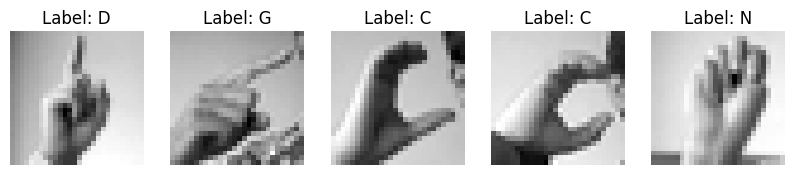

In [91]:
## display images
def display_images(num_images, df):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        # Assuming the first column is the label
        img = df.iloc[i, 1:].values.reshape(28, 28)
        label = df.iloc[i, 0]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {letters[label]}')
        axes[i].axis('off')

    plt.show()
display_images(5, train_df)

In [20]:
## set up cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=32*7*7, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=25) ## 25 classes, for each letter of the alphabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # reshape the tensor
        x = x.view(-1, 32*7*7)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [21]:
#instantiate the model
model = CNN()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=25, bias=True)
)


In [57]:
## training loop
def train(parameters, model, train_loader):
    epochs = parameters['epochs']
    criterion = parameters['criterion']
    optimizer = parameters['optimizer']
    device = parameters['device']
    model = model.to(device)
    train_losses = []
    test_losses = []
    train_corrects = []
    test_corrects = []
    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            b+=1
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_losses.append(loss)

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            train_corrects.append(trn_corr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if b%200 == 0:
                print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{60000}]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(32*b):7.3f}%')
        test_correct, test_loss = evaluate(model, test_loader, criterion=criterion)    
        test_corrects.append(tst_corr)
        test_losses.append(test_loss)
    return (train_losses, test_losses, train_corrects, test_corrects)
def evaluate(model, test_loader, criterion):
    correct = 0
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = model(X_test)
            loss = criterion(y_val, y_test)
            predicted = torch.max(y_val.data, 1)[1]
            correct += (predicted == y_test).sum()
    print(f'Test accuracy: {correct.item()}/{test_length} = {correct.item()*100/(test_length):7.3f}%')
    return correct.item()*100/(test_length), loss

In [58]:
parameters = {'epochs': 5, 'criterion': criterion, 'optimizer': optimizer, 'device': device}
train_losses, test_losses, train_correct, test_correct = train(parameters, model, train_loader)

C:\Users\Lucy\AppData\Local\Temp\ipykernel_5520\1300528031.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


epoch:  0  batch:  200 [  2000/60000]  loss: 0.00000093 accuracy: 100.000%
epoch:  0  batch:  400 [  4000/60000]  loss: 0.00000039 accuracy: 100.000%
epoch:  0  batch:  600 [  6000/60000]  loss: 0.00000205 accuracy: 100.000%
epoch:  0  batch:  800 [  8000/60000]  loss: 0.02138916 accuracy:  98.926%
Test accuracy: 6701/7172 =  93.433%
epoch:  1  batch:  200 [  2000/60000]  loss: 0.00131405 accuracy:  99.969%
epoch:  1  batch:  400 [  4000/60000]  loss: 0.00012248 accuracy:  99.984%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00025571 accuracy:  99.990%
epoch:  1  batch:  800 [  8000/60000]  loss: 0.00012422 accuracy:  99.992%
Test accuracy: 6753/7172 =  94.158%
epoch:  2  batch:  200 [  2000/60000]  loss: 0.00017579 accuracy: 100.000%
epoch:  2  batch:  400 [  4000/60000]  loss: 0.00003471 accuracy: 100.000%
epoch:  2  batch:  600 [  6000/60000]  loss: 0.00003635 accuracy: 100.000%
epoch:  2  batch:  800 [  8000/60000]  loss: 0.00001073 accuracy: 100.000%
Test accuracy: 6759/7172 =  

Label: L


C:\Users\Lucy\AppData\Local\Temp\ipykernel_5520\1300528031.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


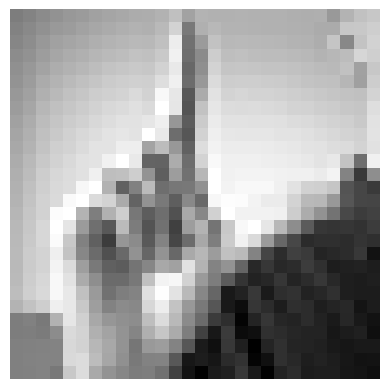

Prediction: L


In [106]:
## okay so now i need to create the user friendly parts

## create a function that takes in an image and returns the prediction

def predict(model, image):
    model.eval()
    image = image.to(device)
    image = image.unsqueeze(0)
    output = model(image)
    predicted = torch.max(output.data, 1)[1]
    return predicted


    # Get one image from the test dataset
image, label = next(iter(test_loader))
image = image[0].view(1, 28, 28)
pred = predict(model, image)
print(f'Label: {letters[label[0].item()]}')

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

print(f'Prediction: {letters[pred.item()]}')


In [107]:
## save model
torch.save(model.state_dict(), 'sign_language_model.pt')